In [1]:
import datasets
import matplotlib as plt
import tokenize
import transformers
from typing import Union
import numpy as np

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the data from the policyqa folder
dataset = datasets.load_dataset('json', data_files={'train': 'policyqa/train.json', 'dev': 'policyqa/dev.json', 'test': 'policyqa/test.json'}, field='data') 


Using custom data configuration default-0c63ba6e2e28f3b2
Reusing dataset json (/home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 3/3 [00:00<00:00, 56.24it/s]


In [3]:
# print the keys of the training dataset
print(dataset['test'][0]['paragraphs'][10:11][0])
print(dataset['test'][0].keys())

{'context': 'create and deliver personalized promotions, including by combining your Personal Information with Other Information, such as the amounts and types of bookings or itineraries you make and discounts or benefits you use', 'index': 11, 'qas': [{'answers': [{'answer_start': 67, 'text': 'your Personal Information'}], 'id': 'wo1uc0blyt1k5tsx', 'question': 'What type of information about me does the website collect?', 'type': 'First Party Collection/Use|||Personal Information Type|||Generic personal information'}, {'answers': [{'answer_start': 0, 'text': 'create and deliver personalized promotions'}], 'id': 'vycw7xem04dd090w', 'question': 'For what purpose do you use my data?', 'type': 'First Party Collection/Use|||Purpose|||Basic service/feature'}, {'answers': [{'answer_start': 57, 'text': 'combining your Personal Information with Other Information'}], 'id': '78981ujzwheh9wvj', 'question': 'Does the company collect my personal information?', 'type': 'First Party Collection/Use|||

In [4]:
def make_dataset_use_entire_document_as_context(row):
    """
    Convert the paragraphs into documents by:
    1. Iteratre over each paragraph in the document (supplied row)
    2. Concatenate all of the paragraphs' contexts together to form a single document
    3. Update the 'context' field of each paragraph to be the document
    4. Update the start of each answer to be the start of the answer in the document
    :param row: a row from the dataset representing a single document
    :return: the updated dataset.
    """
    
    # join all of the contexts together to form a single document, separating each with a newline
    entire_document = '\n'.join([paragraph['context'] for paragraph in row['paragraphs']])

    # the offset relative to the start of the document
    context_offset = 0 

    for paragraph in row['paragraphs']:
        original_context = paragraph['context']
        paragraph['context'] = entire_document
        for qa in paragraph['qas']:
            for answer in qa['answers']:
                answer['answer_start'] += context_offset

        # update the context offset for the next paragraph
        context_offset += len(original_context) + 1 # +1 for the newline character

    return row


def check_answer_offsets(row):
    """
    Check that the answer offsets are correct
    :param row: a row from the dataset representing a single document
    :return: Nothing
    """
    for paragraph in row['paragraphs']:
        for qa in paragraph['qas']:
            for answer in qa['answers']:
                start = answer['answer_start']
                selected_from_context = paragraph['context'][start:start + len(answer['text'])]
                actual_text = answer['text']
                assert selected_from_context == actual_text, f"Expected {actual_text} but got {selected_from_context}"


In [5]:
long_dataset = dataset.map(make_dataset_use_entire_document_as_context)

long_dataset.map(check_answer_offsets)


Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-65abccdedecce8d4.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-582e8398e77ad788.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-11c106718e48addd.arrow
100%|██████████| 20/20 [00:00<00:00, 70.56ex/s]


DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 75
    })
    dev: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 20
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 20
    })
})

In [6]:
DatasetUnion = Union[datasets.DatasetDict, datasets.Dataset, datasets.IterableDatasetDict, datasets.IterableDataset]

class LongSquadConfig(datasets.BuilderConfig):

    def __init__(self, **kwargs):
        super(LongSquadConfig, self).__init__(**kwargs)

class LongSquad(datasets.GeneratorBasedBuilder):

    BUILDER_CONFIGS = [
        LongSquadConfig(name="squad_v2", version=datasets.Version("2.0.0"), description="SQuAD plain text version 2"),
    ]

    # def _info(self):
    #     return datasets.DatasetInfo(
    #         features=datasets.Features(
    #             {
    #                 "id": datasets.Value("string"),
    #                 "title": datasets.Value("string"),
    #                 "context": datasets.Value("string"),
    #                 "question": datasets.Value("string"),
    #                 "answers": datasets.features.Sequence(
    #                     {
    #                         "text": datasets.Value("string"),
    #                         "answer_start": datasets.Value("int32"),
    #                     }
    #                 ),
    #             }
    #         ),
    #         supervised_keys=None,
    #         task_templates=[
    #             datasets.tasks.QuestionAnsweringExtractive(
    #                 question_column="question", context_column="context", answers_column="answers"
    #             )
    #         ],
    #     )

    def _generate_examples(self, **kwargs):
        """Yields examples."""
        # TODO(squad_v2): Yields (key, example) tuples from the dataset
        # with open(filepath, encoding="utf-8") as f:
            # squad = json.load(f)
        for example in long_dataset['train']:
            title = example.get("title", "")
            for paragraph in example["paragraphs"]:
                context = paragraph["context"]
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    id_ = qa["id"]

                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"] for answer in qa["answers"]]

                    # Features currently used are "context", "question", and "answers".
                    # Others are extracted here for the ease of future expansions.
                    yield id_, {
                        "title": title,
                        "context": context,
                        "question": question,
                        "id": id_,
                        "answers": {
                            "answer_start": answer_starts,
                            "text": answers,
                        },
                    }

wrapped_dataset = LongSquad(dataset)

TypeError: <module '__main__'> is a built-in module

In [24]:
# tokenize each context from the training dataset

only_documents = long_dataset.map(lambda x: { "document":  x['paragraphs'][0]['context']})
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased', force_download=False, use_fast=True)
tokenized_long_dataset = only_documents.map(lambda x: tokenizer(x['document'], padding="longest", truncation=True, return_tensors="pt", max_length=10000, return_special_tokens_mask=True))




Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-6003dbf6f26556e6.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-9c89458cd5cce100.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-0c63ba6e2e28f3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-95532e3799bb0f8a.arrow
100%|██████████| 20/20 [00:01<00:00, 10.25ex/s]


In [25]:
print(tokenized_long_dataset['train'][0].keys())
print(len(tokenized_long_dataset['train'][0]["input_ids"][0]))

dict_keys(['title', 'paragraphs', 'document', 'input_ids', 'token_type_ids', 'special_tokens_mask', 'attention_mask'])
4090


Average length: 2814.28
Median length: 2881.0
Max length: 9336
Min length: 116


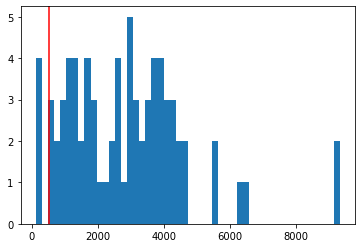

In [39]:
# print the length of all the tokenized documents as a histogram
data = [len(x["input_ids"][0]) for x in tokenized_long_dataset['train']]
plot = plt.pyplot.hist(data, bins=50)

# plot vertical line at 512
plt.pyplot.axvline(x=512, color='r', linestyle='-')

print(f"Average length: {np.mean(data)}")
print(f"Median length: {np.median(data)}")
print(f"Max length: {np.max(data)}")
print(f"Min length: {np.min(data)}")

In [32]:
short_documents = [x for x in tokenized_long_dataset['train'] if len(x["input_ids"][0]) <= 512]
print(f"Number of documents with less than 512 tokens: {len(short_documents)}")
for doc in short_documents:
    print(f"Document length: {len(doc['input_ids'][0])}")
    print(doc['paragraphs'][0]['context'])


Number of documents with less than 512 tokens: 4
Document length: 141
Privacy Statement We allow third-party companies to serve ads and/or collect certain anonymous information when you visit our web site. These companies may use non-personally identifiable information (e.g., click stream information, browser type, time and date, subject of advertisements clicked or scrolled over) during your visits to this and other Web sites in order to provide advertisements about goods and services likely to be of greater interest to you. These companies typically use a cookie or third party web beacon to collect this information. To learn more about this behavioral advertising practice or to opt-out of this type of advertising, you can visit networkadvertising.org.
Document length: 294
Google Adsense and the DoubleClick DART Cookie Google, as a third party advertisement vendor, uses cookies to serve ads on this site. The use of DART cookies by Google enables them to serve adverts to visitors that 